# Lab 3.6 Generating Model Performance Metrics

created by ACZ 202402

In [1]:
bucket='c109190a2572290l5909992t1w471112808786-labbucket-2ginounxer7g'

In [2]:
import warnings, requests, zipfile, io
warnings.simplefilter('ignore')
import pandas as pd
from scipy.io import arff

import os
import boto3
import sagemaker
from sagemaker.image_uris import retrieve
from sklearn.model_selection import train_test_split

sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /home/ec2-user/.config/sagemaker/config.yaml


In [3]:
f_zip = 'http://archive.ics.uci.edu/ml/machine-learning-databases/00212/vertebral_column_data.zip'
r = requests.get(f_zip, stream=True)
Vertebral_zip = zipfile.ZipFile(io.BytesIO(r.content))
Vertebral_zip.extractall()

data = arff.loadarff('column_2C_weka.arff')
df = pd.DataFrame(data[0])

class_mapper = {b'Abnormal':1,b'Normal':0}
df['class']=df['class'].replace(class_mapper)

cols = df.columns.tolist()
cols = cols[-1:] + cols[:-1]
df = df[cols]

train, test_and_validate = train_test_split(df, test_size=0.2, random_state=42, stratify=df['class'])
test, validate = train_test_split(test_and_validate, test_size=0.5, random_state=42, stratify=test_and_validate['class'])

prefix='lab3'

train_file='vertebral_train.csv'
test_file='vertebral_test.csv'
validate_file='vertebral_validate.csv'

s3_resource = boto3.Session().resource('s3')
def upload_s3_csv(filename, folder, dataframe):
    csv_buffer = io.StringIO()
    dataframe.to_csv(csv_buffer, header=False, index=False )
    s3_resource.Bucket(bucket).Object(os.path.join(prefix, folder, filename)).put(Body=csv_buffer.getvalue())

upload_s3_csv(train_file, 'train', train)
upload_s3_csv(test_file, 'test', test)
upload_s3_csv(validate_file, 'validate', validate)

container = retrieve('xgboost',boto3.Session().region_name,'1.0-1')

hyperparams={"num_round":"42",
             "eval_metric": "auc",
             "objective": "binary:logistic"}

s3_output_location="s3://{}/{}/output/".format(bucket,prefix)
xgb_model=sagemaker.estimator.Estimator(container,
                                       sagemaker.get_execution_role(),
                                       instance_count=1,
                                       instance_type='ml.m4.xlarge',
                                       output_path=s3_output_location,
                                        hyperparameters=hyperparams,
                                        sagemaker_session=sagemaker.Session())

train_channel = sagemaker.inputs.TrainingInput(
    "s3://{}/{}/train/".format(bucket,prefix,train_file),
    content_type='text/csv')

validate_channel = sagemaker.inputs.TrainingInput(
    "s3://{}/{}/validate/".format(bucket,prefix,validate_file),
    content_type='text/csv')

data_channels = {'train': train_channel, 'validation': validate_channel}

xgb_model.fit(inputs=data_channels, logs=False)

batch_X = test.iloc[:,1:];

batch_X_file='batch-in.csv'
upload_s3_csv(batch_X_file, 'batch-in', batch_X)

batch_output = "s3://{}/{}/batch-out/".format(bucket,prefix)
batch_input = "s3://{}/{}/batch-in/{}".format(bucket,prefix,batch_X_file)

xgb_transformer = xgb_model.transformer(instance_count=1,
                                       instance_type='ml.m4.xlarge',
                                       strategy='MultiRecord',
                                       assemble_with='Line',
                                       output_path=batch_output)

xgb_transformer.transform(data=batch_input,
                         data_type='S3Prefix',
                         content_type='text/csv',
                         split_type='Line')
xgb_transformer.wait()

s3 = boto3.client('s3')
obj = s3.get_object(Bucket=bucket, Key="{}/batch-out/{}".format(prefix,'batch-in.csv.out'))
target_predicted = pd.read_csv(io.BytesIO(obj['Body'].read()),names=['class'])

INFO:sagemaker:Creating training-job with name: sagemaker-xgboost-2024-02-23-13-15-44-845



2024-02-23 13:15:45 Starting - Starting the training job..
2024-02-23 13:16:00 Starting - Preparing the instances for training...............
2024-02-23 13:17:24 Downloading - Downloading input data........
2024-02-23 13:18:08 Downloading - Downloading the training image.......
2024-02-23 13:18:49 Training - Training image download completed. Training in progress...
2024-02-23 13:19:04 Uploading - Uploading generated training model..
2024-02-23 13:19:20 Completed - Training job completed

INFO:sagemaker:Creating model with name: sagemaker-xgboost-2024-02-23-13-19-22-191


INFO:sagemaker:Creating transform job with name: sagemaker-xgboost-2024-02-23-13-19-22-757


.......................................
[2024-02-23:13:25:50:INFO] No GPUs detected (normal if no gpus installed)
[2024-02-23:13:25:50:INFO] No GPUs detected (normal if no gpus installed)
[2024-02-23:13:25:50:INFO] nginx config: 
worker_processes auto;
daemon off;
pid /tmp/nginx.pid;
error_log  /dev/stderr;
worker_rlimit_nofile 4096;
events {
  worker_connections 2048;
}
http {
  include /etc/nginx/mime.types;
  default_type application/octet-stream;
  access_log /dev/stdout combined;
  upstream gunicorn {
    server unix:/tmp/gunicorn.sock;
  }
  server {
    listen 8080 deferred;
    client_max_body_size 0;
    keepalive_timeout 3;
    location ~ ^/(ping|invocations|execution-parameters) {
      proxy_set_header X-Forwarded-For $proxy_add_x_forwarded_for;
      proxy_set_header Host $http_host;
      proxy_redirect off;
      proxy_read_timeout 60s;
      proxy_pass http://gunicorn;
    }
    location / {
      return 404 "{}";
    }
  }
}
[2024-02-23 13:25:50 +0000] [19] [INFO] Star

In [21]:
target_predicted['class'].head(10)

0    0.996607
1    0.777283
2    0.994641
3    0.993690
4    0.939139
5    0.997396
6    0.991977
7    0.987518
8    0.993334
9    0.682776
Name: class, dtype: float64

In [102]:
def binary_convert(x):
    threshold = 0.75
    if x > threshold:
        return 1
    else:
        return 0

target_predicted_binary = target_predicted['class'].apply(binary_convert)

print(target_predicted_binary.head(10))
test.head(10)

0    1
1    1
2    1
3    1
4    1
5    1
6    1
7    1
8    1
9    0
Name: class, dtype: int64


,class,pelvic_incidence,pelvic_tilt,lumbar_lordosis_angle,sacral_slope,pelvic_radius,degree_spondylolisthesis
136,1,88.024499,39.844669,81.774473,48.179830,116.601538,56.766083
230,0,65.611802,23.137919,62.582179,42.473883,124.128001,-4.083298
134,1,52.204693,17.212673,78.094969,34.992020,136.972517,54.939134
130,1,50.066786,9.120340,32.168463,40.946446,99.712453,26.766697
47,1,41.352504,16.577364,30.706191,24.775141,113.266675,-4.497958
135,1,77.121344,30.349874,77.481083,46.771470,110.611148,82.093607
100,1,84.585607,30.361685,65.479486,54.223922,108.010218,25.118478
89,1,71.186811,23.896201,43.696665,47.290610,119.864938,27.283985
297,0,45.575482,18.759135,33.774143,26.816347,116.797007,3.131910
4,1,49.712859,9.652075,28.317406,40.060784,108.168725,7.918501


convert probability score with 0.3 treshold into 0 or 1

In [103]:
test_labels = test.iloc[:,0]
test_labels.head(10)

136    1
230    0
134    1
130    1
47     1
135    1
100    1
89     1
297    0
4      1
Name: class, dtype: int64

In [104]:
from sklearn.metrics import confusion_matrix

matrix = confusion_matrix(test_labels, target_predicted_binary)
df_confusion = pd.DataFrame(matrix, index=['Nnormal','Abnormal'],columns=['Normal','Abnormal'])

df_confusion

,Normal,Abnormal
Nnormal,7,3
Abnormal,5,16


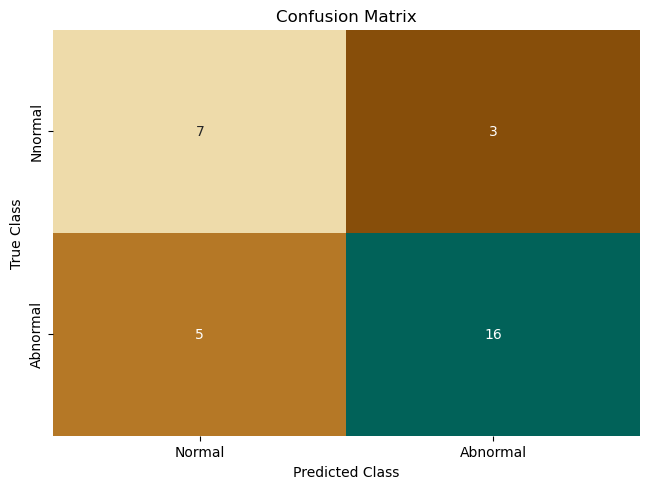

In [105]:
import seaborn as sns
import matplotlib.pyplot as plt

colormap = sns.color_palette("BrBG", 10)
sns.heatmap(df_confusion, annot=True, cbar=None, cmap=colormap)
plt.title("Confusion Matrix")
plt.tight_layout()
plt.ylabel("True Class")
plt.xlabel("Predicted Class")
plt.show()

In [106]:
from sklearn.metrics import roc_auc_score, roc_curve, auc

TN, FP, FN, TP = confusion_matrix(test_labels, target_predicted_binary).ravel()

print(f"True Negative (TN) : {TN}")
print(f"False Positive (FP): {FP}")
print(f"False Negative (FN): {FN}")
print(f"True Positive (TP) : {TP}")

True Negative (TN) : 7
False Positive (FP): 3
False Negative (FN): 5
True Positive (TP) : 16


In [107]:
# Sensitivity, hit rate, recall, or true positive rate
Sensitivity  = float(TP)/(TP+FN)*100
print(f"Sensitivity or TPR: {Sensitivity}%")  
print(f"There is a {Sensitivity}% chance of detecting patients with an abnormality have an abnormality")

Sensitivity or TPR: 76.19047619047619%
There is a 76.19047619047619% chance of detecting patients with an abnormality have an abnormality


Sensitivity = TP/(TP+FN)

In [108]:
# Specificity or true negative rate
Specificity  = float(TN)/(TN+FP)*100
print(f"Specificity or TNR: {Specificity}%") 
print(f"There is a {Specificity}% chance of detecting normal patients are normal.")

Specificity or TNR: 70.0%
There is a 70.0% chance of detecting normal patients are normal.


Specificity = TN/(TN+FP)

In [109]:
# Precision or positive predictive value
Precision = float(TP)/(TP+FP)*100
print(f"Precision: {Precision}%")  
print(f"You have an abnormality, and the probablity that is correct is {Precision}%")

Precision: 84.21052631578947%
You have an abnormality, and the probablity that is correct is 84.21052631578947%


Precision = TP/(TP+FP)

In [110]:
# Negative predictive value
NPV = float(TN)/(TN+FN)*100
print(f"Negative Predictive Value: {NPV}%") 
print(f"You don't have an abnormality, but there is a {NPV}% chance that is incorrect" )

Negative Predictive Value: 58.333333333333336%
You don't have an abnormality, but there is a 58.333333333333336% chance that is incorrect


NPV (Inverse-Precision) = TN/(TN+FN)

In [111]:
# Fall out or false positive rate
FPR = float(FP)/(FP+TN)*100
print( f"False Positive Rate: {FPR}%") 
print( f"There is a {FPR}% chance that this positive result is incorrect.")

False Positive Rate: 30.0%
There is a 30.0% chance that this positive result is incorrect.


FPR = FP/(TN+FP)

In [112]:
# False negative rate
FNR = float(FN)/(TP+FN)*100
print(f"False Negative Rate: {FNR}%") 
print(f"There is a {FNR}% chance that this negative result is incorrect.")

False Negative Rate: 23.809523809523807%
There is a 23.809523809523807% chance that this negative result is incorrect.


FNR = FN/(TP+FN)

In [113]:
# False discovery rate
FDR = float(FP)/(TP+FP)*100
print(f"False Discovery Rate: {FDR}%" )
print(f"You have an abnormality, but there is a {FDR}% chance this is incorrect.")

False Discovery Rate: 15.789473684210526%
You have an abnormality, but there is a 15.789473684210526% chance this is incorrect.


FDR = FP/(TP+FP)

In [114]:
# Overall accuracy
ACC = float(TP+TN)/(TP+FP+FN+TN)*100
print(f"Accuracy: {ACC}%") 

Accuracy: 74.19354838709677%


Accuracy = correct prediction/all prediction

In [115]:
print(f"Sensitivity or TPR: {Sensitivity}%")    
print(f"Specificity or TNR: {Specificity}%") 
print(f"Precision: {Precision}%")   
print(f"Negative Predictive Value: {NPV}%")  
print( f"False Positive Rate: {FPR}%") 
print(f"False Negative Rate: {FNR}%")  
print(f"False Discovery Rate: {FDR}%" )
print(f"Accuracy: {ACC}%") 

Sensitivity or TPR: 76.19047619047619%
Specificity or TNR: 70.0%
Precision: 84.21052631578947%
Negative Predictive Value: 58.333333333333336%
False Positive Rate: 30.0%
False Negative Rate: 23.809523809523807%
False Discovery Rate: 15.789473684210526%
Accuracy: 74.19354838709677%


In [116]:
test_labels = test.iloc[:,0];
print("Validation AUC", roc_auc_score(test_labels, target_predicted) )

Validation AUC 0.8904761904761904


The ROC is a probability curve<br>
The AUC tells you how well the model can distinguish between classes<br>
The higher the AUC, the better the model is at distinguishing between abnormal and normal patients

Figure(640x480)


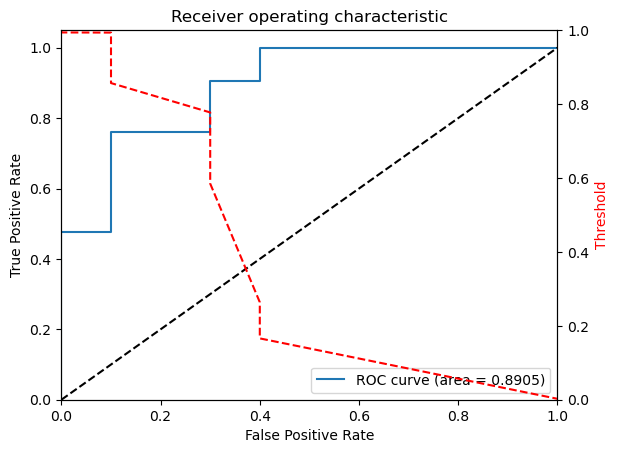

<Figure size 640x480 with 0 Axes>

In [117]:
fpr, tpr, thresholds = roc_curve(test_labels, target_predicted)
# print(fpr)
# print(tpr)
# print(thresholds)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, label='ROC curve (area = %0.4f)' % (roc_auc))
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
 
# create the axis of thresholds (scores)
ax2 = plt.gca().twinx()
ax2.plot(fpr, thresholds, markeredgecolor='r',linestyle='dashed', color='r')
ax2.set_ylabel('Threshold',color='r')
ax2.set_ylim([0,1])
ax2.set_xlim([fpr[0],fpr[-1]])

print(plt.figure())